# Loan Repayment Prediction using Random Forest (Кредитоспособност)

This notebook trains a Random Forest classifier to predict if a loan
is paid back, using one-hot encoded categorical features and 5-fold stratified cross-validation.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("../loan_dataset_20000.csv") 

X_raw = df.drop("loan_paid_back", axis=1)
y = df["loan_paid_back"]

# monthly and yearly income carry the same info monhly = yearly / 12
X_raw = X_raw.drop(columns=['monthly_income'])

X = X_raw.copy()
y = y.copy()

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [4]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

target_col = "loan_paid_back" 
X = df.drop(columns=[target_col])
y = df[target_col]

# stratify keeps the 0/1 ratio similar in train and test (important for FP/FN work)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)


In [5]:
classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

pipeline_rfc = Pipeline([
    ('prep', preprocessor_tree),
    ('model', classifier)
])
pipeline_rfc.fit(X_train, y_train)

y_pred_rfc = pipeline_rfc.predict(X_test)
y_proba_rfc = pipeline_rfc.predict_proba(X_test)[:, 1]


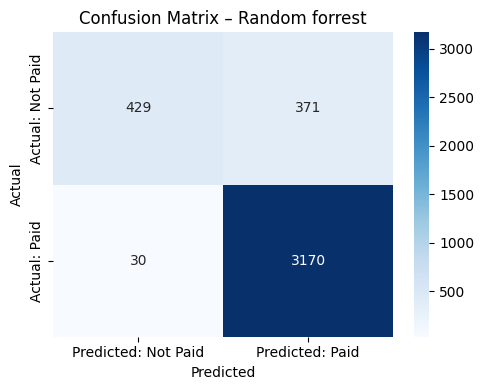

              precision    recall  f1-score   support

           0       0.93      0.54      0.68       800
           1       0.90      0.99      0.94      3200

    accuracy                           0.90      4000
   macro avg       0.91      0.76      0.81      4000
weighted avg       0.90      0.90      0.89      4000



In [6]:
cm = confusion_matrix(y_test, y_pred_rfc)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted: Not Paid', 'Predicted: Paid'],
    yticklabels=['Actual: Not Paid', 'Actual: Paid']
)
plt.title('Confusion Matrix – Random forrest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_rfc))


In [8]:
# 1) земи ги имињата по preprocessing
prep = pipeline_rfc.named_steps["prep"]
feature_names = prep.get_feature_names_out()


rf = pipeline_rfc.named_steps["model"]
importances = classifier.feature_importances_

# 3) испечати feature_name : importance
for name, value in sorted(
    zip(feature_names, importances),
    key=lambda x: x[1],
    reverse=True
):
    print(f"{name} : {value}")


cat__employment_status_Unemployed : 0.18343497699858113
num__debt_to_income_ratio : 0.09054071767519191
num__credit_score : 0.07540305706516998
cat__employment_status_Employed : 0.05907877916039838
num__interest_rate : 0.04822612203458581
num__installment : 0.040252151874037544
num__total_credit_limit : 0.04011504035382768
num__current_balance : 0.039794918379270044
num__annual_income : 0.03971493414872457
num__loan_amount : 0.038446132731308404
num__age : 0.03528370460882413
cat__employment_status_Student : 0.03427412499212601
cat__employment_status_Self-employed : 0.028476068256103715
num__num_of_open_accounts : 0.025592072371990463
cat__employment_status_Retired : 0.023675070558089182
num__num_of_delinquencies : 0.018616990777532486
num__delinquency_history : 0.01840506549028196
cat__marital_status_Married : 0.006695937004635714
cat__loan_purpose_Debt consolidation : 0.006649655170127723
cat__marital_status_Single : 0.006598485435931814
cat__education_level_Bachelor's : 0.0065978345

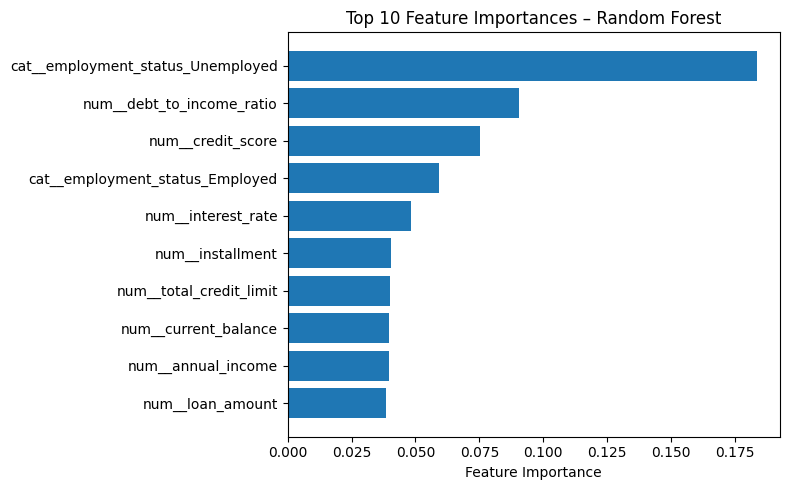

In [9]:
indices = np.argsort(importances)[-10:]
top_features = feature_names[indices]
top_importances = importances[indices]

# 4) plot
plt.figure(figsize=(8, 5))
plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()